In [1]:
import numpy as np
import seaborn as sns
cm = sns.color_palette()
from scipy.spatial import *
import matplotlib.pyplot as plt
%matplotlib inline

## Задание 11
# Метод конечных элементов
## Триангуляция области
Здесь задается и  триангулируется область решения

In [10]:
h = 0.5
det = h**2

In [11]:
def make_tri(h):
    points = [[x,y] for y in np.arange(0, 3+h, h) for x in np.arange(0, 1+h, h)]
    points += [[x,y] for y in np.arange(0, 1+h, h) for x in np.arange(1+h, 2+h, h)]
    points = np.array(points)
    tri = Delaunay(points)
    tri.simplices = tri.simplices[
        (points[tri.simplices][:,:, 0].max(1) <= 1) | 
        (points[tri.simplices][:,:, 1].max(1) <= 1)]
    inner_points_index = ((points[:,0]>0) & (points[:,1]>0) & 
                      (points[:,0]<2) & (points[:,1]<3) & ~
                      ((points[:,0]>=1) & (points[:,1]>=1)))
    inner_points = points[inner_points_index]
    return points, tri, inner_points, inner_points_index

points, tri, inner_points, inner_points_index = make_tri(h)

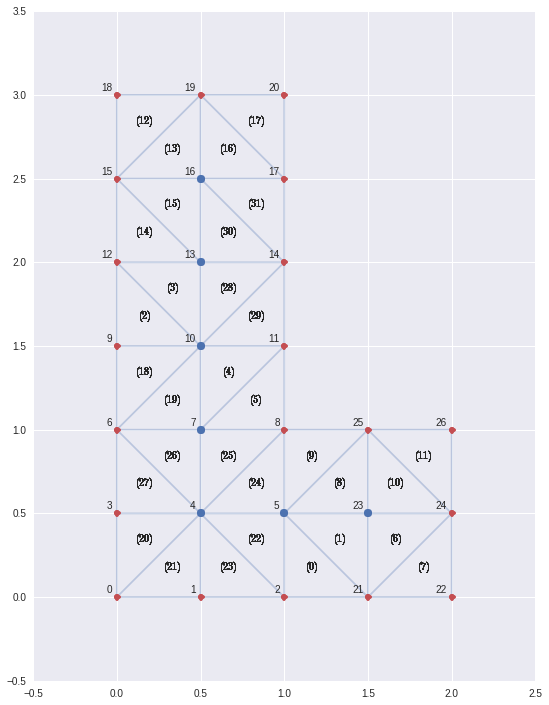

In [12]:
def plot_tri(marked=False):
    plt.figure(figsize=(3*3, 4*3))
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), alpha=0.3)
    plt.plot(points[:,0], points[:,1], 'o')
    plt.plot(inner_points[:,0], inner_points[:,1], 'o', color=cm[0], markersize=8)

    if marked:
        for j, p in enumerate(points):
            plt.text(p[0]-0.03, p[1]+0.03, j, ha='right') # label the points
            for j, s in enumerate(tri.simplices):
                p = points[s].mean(axis=0)
                plt.text(p[0], p[1], '$('+str(j)+')$', ha='center') # label triangles
    plt.xlim(-0.5, 2.5); plt.ylim(-0.5, 3.5)

plot_tri(True)

## Формироване матрицы жесткости и решение

In [13]:
def localK(r):
    x = points[tri.simplices[r]].T
    i = 0
    j = 1
    k = 2
    one = 0
    two = 1
    Kr = np.zeros((3,3))
    Kr[0,0] = (x[two, j] - x[two, k])**2 + (x[one, k] - x[one, j])**2
    Kr[0,1] = (x[two, k] - x[two, i])*(x[two, j] - x[two, k]) + (x[one, i] - x[one, k])*(x[one, k] - x[one, j])
    Kr[0,2] = (x[two, i] - x[two, j])*(x[two, j] - x[two, k]) + (x[one, j] - x[one, i])*(x[one, k] - x[one, j])
    Kr[1,1] = (x[two, k] - x[two, i])**2 + (x[one, i] - x[one, k])**2
    Kr[1,2] = (x[two, i] - x[two, j])*(x[two, k] - x[two, i]) + (x[one, j] - x[one, i])*(x[one, i] - x[one, k])
    Kr[2,2] = (x[two, i] - x[two, j])**2 + (x[one, j] - x[one, i])**2
    Kr[1,0] = Kr[0, 1]
    Kr[2,0] = Kr[0, 2]
    Kr[2,1] = Kr[1, 2]
    return Kr/det

def C(r):
    simplex = tri.simplices[r]
    C = np.zeros((3, points.shape[0]))
    for i in range(3):
        C[i, simplex[i]] = 1
    return C

def localF(r):
    simplex = tri.simplices[r]
    fr = np.ones((3, ))/2/3*det
    for i in range(3):
        if simplex[i] not in np.arange(0, points.shape[0])[inner_points_index]:
            fr[i] = 0
    return fr

In [14]:
def solve():
    K = sum(np.dot(C(r).T, np.dot(localK(r), C(r))) for r in range(tri.simplices.shape[0]))
    f = sum(np.dot(C(r).T, localF(r)) for r in range(tri.simplices.shape[0]))
    for r in range(points.shape[0]):
        if r not in np.arange(0, points.shape[0])[inner_points_index]:
            K[r,:] = 0
            K[:,r] = 0
            K[r,r] = 1
    return np.dot(np.linalg.inv(K),f)

u = solve()

## Построение решения
Здесь строится решение. Значение отображатся цветом: черный соответствует максимальному значению, белый - минимальному, остальные значения по градиенту.

black: max(u) = 0.0711102417771
white: min(u) = 0.0


/home/nikolai/PycharmProjects/venvs/dataSci/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


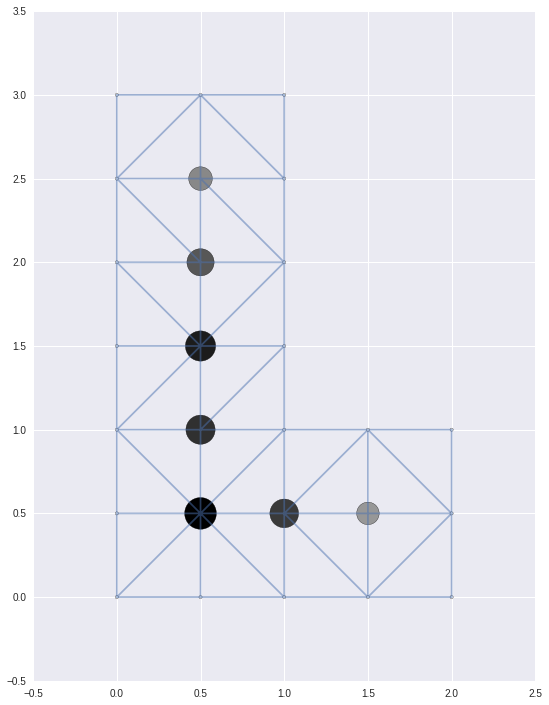

In [15]:
def plot_solution():
    print('black: max(u) =', max(u))
    print('white: min(u) =', min(u))
    plt.figure(figsize=(3*3, 4*3))
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), alpha=0.5)
    plt.scatter(points[:,0], points[:,1], s=2000*h*u/max(u) +10, c=u)
plot_solution()

## Более плотная сетка
Здесь строится более плотная триангуляция и вычисляется решение

black: max(u) = 0.0745267782704
white: min(u) = 0.0


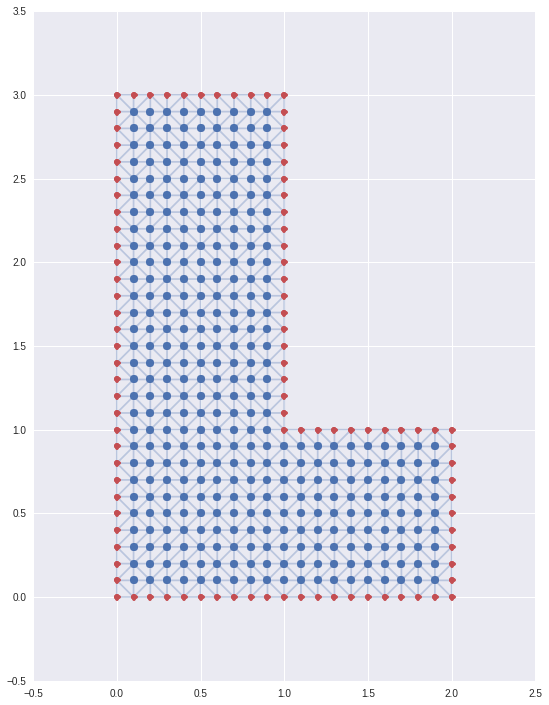

/home/nikolai/PycharmProjects/venvs/dataSci/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


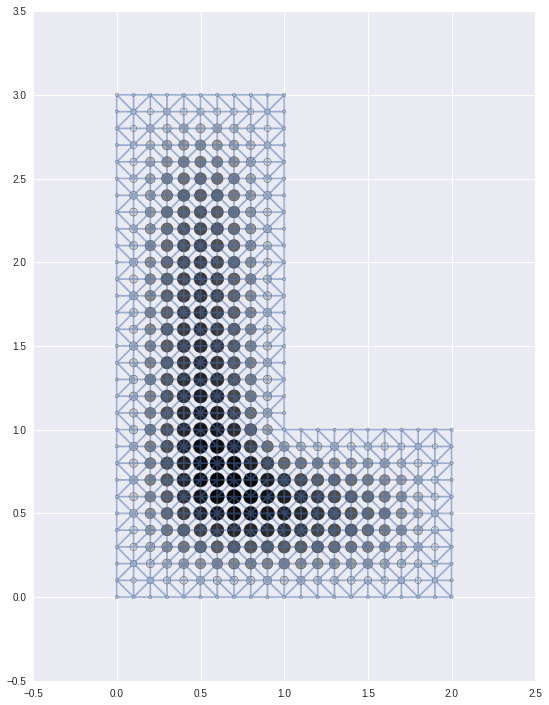

In [17]:
h = 0.1
det = h**2
points, tri, inner_points, inner_points_index = make_tri(h)
u = solve()
plot_tri()
plot_solution()